# 04: Attention

*The fish grows eyes.*

---

In notebook 03, we built a bigram model. Each position predicts the next token by looking at *only* the current token. No memory. No context. Just "given X, what's likely next?"

In notebook 03b, we cheated by concatenating multiple tokens—bigram, trigram, 4-gram. More context helped (perplexity dropped from 37 → 24 → 20), but we hit walls:

- **Fixed window size:** A 4-gram can only see 3 previous tokens, no matter what.
- **Equal weighting:** All previous tokens contribute equally, even if some are irrelevant.
- **Parameter explosion:** Vocabulary^n parameters to store all n-grams.
- **Data sparsity:** Most n-grams never appear in training data.

**Attention solves all of these problems.** It lets each position:

1. Look at *all* previous positions (variable context)
2. Decide *which* positions matter (learned weighting)
3. Do this with O(d²) parameters, not O(vocab^n)
4. Generalize to unseen combinations through learned similarity

This notebook adds a single attention layer to the bigram model. That's it. No positional encoding (we add that in 05), no feedforward network (06), no residual connections (07). Just raw attention.

**What we expect:** Even without knowing *where* tokens are (position-blind), attention can learn *what* tokens are relevant. "When predicting after a verb, attend to nouns." The model becomes a bag of *relevant* predecessors, not a bag of *all* predecessors.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import math

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


---

## 1. Data and Tokenizer

Same setup as notebook 03.

In [2]:
from transformers import GPT2TokenizerFast

class LilTokenizer:
    """Compact tokenizer for Lil Transformy."""
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def decode_single(self, token_id):
        if token_id == self.pad_id:
            return '<pad>'
        if token_id == self.unk_id:
            return '<unk>'
        if token_id == self.eos_id:
            return '<eos>'
        if token_id in self.compact_to_gpt2:
            return self.gpt2_tokenizer.decode([self.compact_to_gpt2[token_id]])
        return '<???>'
    
    def __len__(self):
        return self.vocab_size
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            config = json.load(f)
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])


tokenizer = LilTokenizer.load('tokenizer/tokenizer.json')
print(f"Vocabulary size: {len(tokenizer):,}")

Vocabulary size: 4,096


In [3]:
train_data = np.load('data/train_sequences.npy')
val_data = np.load('data/val_sequences.npy')

print(f"Training sequences: {train_data.shape}")
print(f"Validation sequences: {val_data.shape}")
print(f"Context length: {train_data.shape[1]}")

Training sequences: (1851532, 256)
Validation sequences: (18616, 256)
Context length: 256


---

## 2. What Is Attention? (The Intuition)

Before we write any code, let's build the intuition.

### The Problem

Imagine you're at position 10 in a sequence, trying to predict token 11. In the bigram model, you can only see token 10. But what if the right answer depends on token 3? You're stuck.

### The Naive Solution (Doesn't Work)

"Just average all previous tokens!" We tried this in notebook 01. It's terrible. Everything gets blended into mush. If position 3 has the important information and positions 4-9 are noise, averaging destroys the signal.

### The Attention Solution

Instead of averaging equally, **let each position compute its own weighted average.**

Position 10 can decide: "I care a lot about position 3, a little about position 7, and almost nothing about positions 4-6." The weights are *learned* based on the content.

### The Mechanism: Query, Key, Value

This is where it gets weird. Bear with me.

We transform each token's embedding into **three different vectors**:

- **Query (Q):** "What am I looking for?"
- **Key (K):** "What do I have to offer?"
- **Value (V):** "What information do I carry?"

The attention weight from position i to position j is computed by:

```
weight(i → j) = softmax( Q_i · K_j / √d )
```

In words: "How much does what position i is looking for match what position j has to offer?"

The output at position i is:

```
output_i = Σ_j weight(i → j) × V_j
```

A weighted sum of everyone's values, where the weights come from query-key matching.

### Why Three Separate Projections?

This is the part that feels like magic. Why not just use the embedding directly?

Think of it this way:

- The **key** is like a label on a file folder: "I contain information about [nouns/verbs/subjects/etc]"
- The **query** is like a search request: "I need information about [nouns/verbs/subjects/etc]"
- The **value** is the actual contents of the folder: the information that gets retrieved

By having separate projections, the model can learn:
- What to *advertise* about each token (key)
- What to *search for* at each position (query)
- What to *retrieve* when matched (value)

These can be different! A token might advertise "I'm a noun" (key), search for "where's my verb?" (query), and carry "the word 'dog'" (value).

### The Causal Constraint

One critical rule: **position i can only attend to positions j ≤ i.**

Why? We're doing *causal* language modeling. Position 10 is trying to predict token 11. It can't look at token 11 to do that—that's cheating. It can't even look at tokens 12, 13, etc.

So we mask out all the "future" positions, forcing attention to only look backward.

### The Scaling Factor

Why divide by √d?

The dot product Q·K grows with dimension d. If we have 128-dimensional vectors, the dot product is the sum of 128 terms. Large dot products → extreme softmax values → vanishing gradients.

Dividing by √d keeps the variance stable regardless of dimension. It's a normalization trick.

### What This Notebook Doesn't Have

We're adding attention in isolation. No:

- **Positional encoding** — the model doesn't know *where* tokens are, just *what* they are
- **Multiple heads** — just one attention pattern
- **Feedforward network** — no per-token processing after attention
- **Residual connections** — attention output goes straight to unembedding
- **Layer normalization** — we'll add this in 07

We're isolating what attention alone contributes.

Let's build it.

---

## 3. Building Attention Step by Step

We'll build attention in pieces, checking each piece as we go.

### Step 1: The Q, K, V Projections

Three linear layers that transform embeddings into queries, keys, and values.

In [4]:
# Let's work with concrete shapes
BATCH_SIZE = 2
SEQ_LEN = 8  # Short for visualization
D_MODEL = 128

# Create some fake embeddings
torch.manual_seed(42)
x = torch.randn(BATCH_SIZE, SEQ_LEN, D_MODEL)
print(f"Input shape: {x.shape}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Sequence length: {SEQ_LEN}")
print(f"  - Embedding dimension: {D_MODEL}")

Input shape: torch.Size([2, 8, 128])
  - Batch size: 2
  - Sequence length: 8
  - Embedding dimension: 128


In [5]:
# The three projections
W_q = nn.Linear(D_MODEL, D_MODEL, bias=False)
W_k = nn.Linear(D_MODEL, D_MODEL, bias=False)
W_v = nn.Linear(D_MODEL, D_MODEL, bias=False)

# Apply them
Q = W_q(x)  # [batch, seq_len, d_model]
K = W_k(x)  # [batch, seq_len, d_model]
V = W_v(x)  # [batch, seq_len, d_model]

print(f"Q shape: {Q.shape}")
print(f"K shape: {K.shape}")
print(f"V shape: {V.shape}")
print()
print("Same shape as input, but different learned transformations.")
print("Each token now has three roles: what it asks (Q), what it offers (K), what it carries (V).")

Q shape: torch.Size([2, 8, 128])
K shape: torch.Size([2, 8, 128])
V shape: torch.Size([2, 8, 128])

Same shape as input, but different learned transformations.
Each token now has three roles: what it asks (Q), what it offers (K), what it carries (V).


### Step 2: Computing Attention Scores

Now we compute how much each position should attend to each other position.

For position i attending to position j:
```
score(i, j) = Q_i · K_j
```

This is a dot product—high score means "what i wants" matches "what j offers."

We need to compute this for all pairs (i, j), which is a matrix multiplication.

In [6]:
# The score between position i and position j is Q_i · K_j
# For all pairs at once: Q @ K^T
#
# Q has shape [batch, seq_len, d_model]
# K has shape [batch, seq_len, d_model]
# K^T has shape [batch, d_model, seq_len]  (transpose last two dims)
# Q @ K^T has shape [batch, seq_len, seq_len]

scores = Q @ K.transpose(-2, -1)

print(f"Scores shape: {scores.shape}")
print()
print(f"This is a {SEQ_LEN}×{SEQ_LEN} matrix for each sequence in the batch.")
print(f"Entry [i, j] = how much position i wants to attend to position j.")
print()
print("Raw scores for batch 0:")
print(scores[0].detach().numpy().round(1))

Scores shape: torch.Size([2, 8, 8])

This is a 8×8 matrix for each sequence in the batch.
Entry [i, j] = how much position i wants to attend to position j.

Raw scores for batch 0:
[[-2.1 -0.7  1.3  1.5 -3.2  0.2 -2.   0.4]
 [-3.  -6.  -5.1 -0.9  2.  -3.8  3.8 -1.4]
 [ 3.2  1.3 -1.2  0.8  2.9 -6.7 -4.1 -4. ]
 [-1.1 -5.4 -4.1  0.3 -1.8  2.8  4.4  0.2]
 [ 1.6  1.2 -1.   5.2  4.1 -5.4  0.1 -1.9]
 [-2.1 -5.4  3.4  2.4  3.5 -4.5  4.3 11. ]
 [ 6.7 -1.2  3.6 -4.8  1.2  1.3 -4.7 -2.4]
 [-0.   2.2  0.6  2.7  1.6  0.4  1.9 -5.4]]


### Step 3: Scaling

Those scores can get big. The dot product of two 128-dimensional vectors can easily be in the hundreds.

Big scores → extreme softmax → saturated gradients.

We divide by √d_model to keep things stable.

In [7]:
scale = math.sqrt(D_MODEL)
print(f"Scaling factor: √{D_MODEL} = {scale:.2f}")
print()

scaled_scores = scores / scale

print("Before scaling (batch 0):")
print(f"  Mean: {scores[0].mean().item():.2f}")
print(f"  Std:  {scores[0].std().item():.2f}")
print(f"  Range: [{scores[0].min().item():.1f}, {scores[0].max().item():.1f}]")
print()
print("After scaling (batch 0):")
print(f"  Mean: {scaled_scores[0].mean().item():.2f}")
print(f"  Std:  {scaled_scores[0].std().item():.2f}")
print(f"  Range: [{scaled_scores[0].min().item():.1f}, {scaled_scores[0].max().item():.1f}]")

Scaling factor: √128 = 11.31

Before scaling (batch 0):
  Mean: -0.18
  Std:  3.50
  Range: [-6.7, 11.0]

After scaling (batch 0):
  Mean: -0.02
  Std:  0.31
  Range: [-0.6, 1.0]


### Step 4: The Causal Mask

Here's where we enforce the rule: **no peeking at the future.**

Position 0 can only see position 0.
Position 1 can see positions 0 and 1.
Position 2 can see positions 0, 1, and 2.
...and so on.

We do this by setting all "future" scores to -∞ before softmax. Then softmax(-∞) = 0, so future positions get zero attention weight.

In [8]:
# Create a mask where True means "this is a future position, block it"
# We want to block positions where j > i (column > row)
#
# For a 4×4 matrix:
#   Position 0 can see: [0]       → mask [_, X, X, X]
#   Position 1 can see: [0, 1]    → mask [_, _, X, X]
#   Position 2 can see: [0, 1, 2] → mask [_, _, _, X]
#   Position 3 can see: [0, 1, 2, 3] → mask [_, _, _, _]
#
# torch.triu with diagonal=1 gives us exactly this pattern (upper triangle, excluding diagonal)

causal_mask = torch.triu(torch.ones(SEQ_LEN, SEQ_LEN), diagonal=1).bool()

print(f"Causal mask shape: {causal_mask.shape}")
print()
print("Mask (True = blocked, can't attend):")
print(causal_mask.int().numpy())
print()
print("Reading: Row i can attend to columns where mask is 0.")
print("Row 0 can only attend to column 0.")
print("Row 7 can attend to columns 0-7 (all positions).")

Causal mask shape: torch.Size([8, 8])

Mask (True = blocked, can't attend):
[[0 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]]

Reading: Row i can attend to columns where mask is 0.
Row 0 can only attend to column 0.
Row 7 can attend to columns 0-7 (all positions).


In [9]:
# Apply the mask: set blocked positions to -infinity
masked_scores = scaled_scores.clone()
masked_scores.masked_fill_(causal_mask, float('-inf'))

print("Masked scores for batch 0 (truncated for readability):")
print()
# Show just the first 5 rows/cols
display_scores = masked_scores[0, :5, :5].detach().numpy()
for i, row in enumerate(display_scores):
    formatted = [f"{v:6.2f}" if v > -1000 else "  -inf" for v in row]
    print(f"  Row {i}: [{', '.join(formatted)}]")
print()
print("The upper triangle is -inf. These positions will get 0 attention after softmax.")

Masked scores for batch 0 (truncated for readability):

  Row 0: [ -0.18,   -inf,   -inf,   -inf,   -inf]
  Row 1: [ -0.26,  -0.53,   -inf,   -inf,   -inf]
  Row 2: [  0.29,   0.11,  -0.11,   -inf,   -inf]
  Row 3: [ -0.10,  -0.48,  -0.36,   0.02,   -inf]
  Row 4: [  0.14,   0.10,  -0.09,   0.46,   0.36]

The upper triangle is -inf. These positions will get 0 attention after softmax.


### Step 5: Softmax to Get Attention Weights

Now we convert scores to probabilities. Each row should sum to 1.

After softmax:
- High scores become high probabilities
- -∞ scores become 0 probabilities (this is how the mask works!)
- Each position's weights over all other positions sum to 1

In [10]:
# Softmax along the last dimension (across the positions we're attending to)
attn_weights = F.softmax(masked_scores, dim=-1)

print(f"Attention weights shape: {attn_weights.shape}")
print()
print("Attention weights for batch 0 (first 5 positions):")
print()
weights_display = attn_weights[0, :5, :5].detach().numpy()
for i, row in enumerate(weights_display):
    formatted = [f"{v:.3f}" for v in row]
    row_sum = row.sum()
    print(f"  Row {i}: [{', '.join(formatted)}] sum={row_sum:.3f}")
print()
print("Notice:")
print("  - Row 0 has all weight on position 0 (can only see itself)")
print("  - Row 1 distributes weight between positions 0 and 1")
print("  - Each row sums to 1")
print("  - Upper triangle is 0 (masked out)")

Attention weights shape: torch.Size([2, 8, 8])

Attention weights for batch 0 (first 5 positions):

  Row 0: [1.000, 0.000, 0.000, 0.000, 0.000] sum=1.000
  Row 1: [0.567, 0.433, 0.000, 0.000, 0.000] sum=1.000
  Row 2: [0.398, 0.334, 0.268, 0.000, 0.000] sum=1.000
  Row 3: [0.279, 0.191, 0.215, 0.315, 0.000] sum=1.000
  Row 4: [0.186, 0.179, 0.147, 0.256, 0.232] sum=1.000

Notice:
  - Row 0 has all weight on position 0 (can only see itself)
  - Row 1 distributes weight between positions 0 and 1
  - Each row sums to 1
  - Upper triangle is 0 (masked out)


### Step 6: Weighted Sum of Values

Finally, we use these attention weights to compute a weighted sum of the value vectors.

Each position gets a mixture of all the positions it attends to, weighted by how much it attends to each.

In [11]:
# attn_weights has shape [batch, seq_len, seq_len]
# V has shape [batch, seq_len, d_model]
#
# For each position i, we want:
#   output_i = Σ_j attn_weights[i,j] × V[j]
#
# This is matrix multiplication: attn_weights @ V
#   [batch, seq_len, seq_len] @ [batch, seq_len, d_model]
#   → [batch, seq_len, d_model]

attn_output = attn_weights @ V

print(f"Attention output shape: {attn_output.shape}")
print()
print("Same shape as input! Each position now contains a weighted mixture of all")
print("the positions it attended to.")
print()
print(f"Position 0 is just V[0] (can only see itself).")
print(f"Position 7 is a mix of V[0] through V[7], weighted by attention.")

Attention output shape: torch.Size([2, 8, 128])

Same shape as input! Each position now contains a weighted mixture of all
the positions it attended to.

Position 0 is just V[0] (can only see itself).
Position 7 is a mix of V[0] through V[7], weighted by attention.


### Visualizing What Just Happened

Let's see the attention pattern:

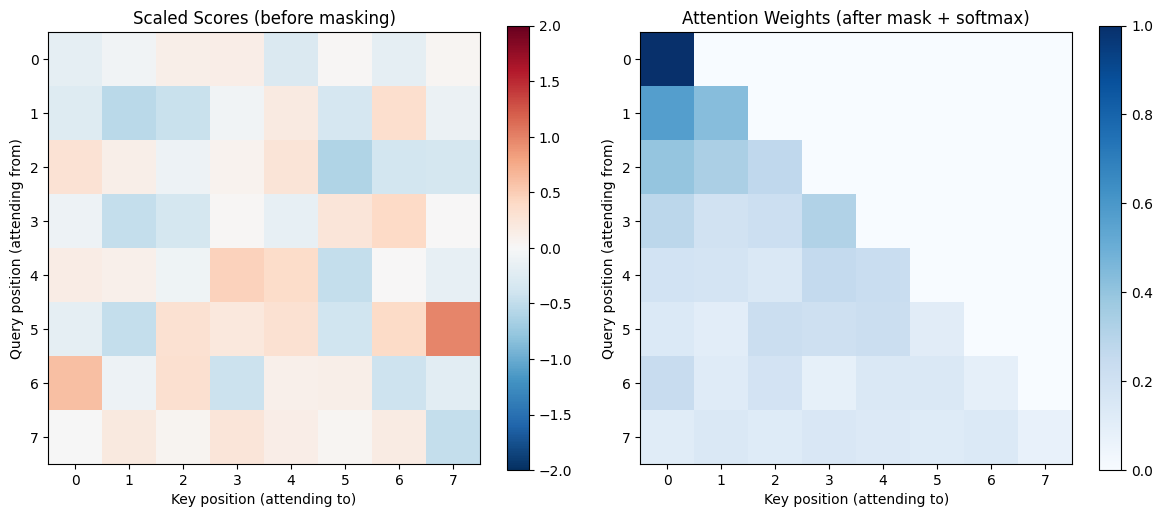

Left: Raw compatibility scores between positions.
Right: Final attention weights. Upper triangle is 0 (causal mask).
Each row in the right plot shows how much that position attends to each previous position.


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw scores (before masking)
ax = axes[0]
im = ax.imshow(scaled_scores[0].detach().numpy(), cmap='RdBu_r', vmin=-2, vmax=2)
ax.set_xlabel('Key position (attending to)')
ax.set_ylabel('Query position (attending from)')
ax.set_title('Scaled Scores (before masking)')
plt.colorbar(im, ax=ax)

# Attention weights (after masking and softmax)
ax = axes[1]
im = ax.imshow(attn_weights[0].detach().numpy(), cmap='Blues')
ax.set_xlabel('Key position (attending to)')
ax.set_ylabel('Query position (attending from)')
ax.set_title('Attention Weights (after mask + softmax)')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("Left: Raw compatibility scores between positions.")
print("Right: Final attention weights. Upper triangle is 0 (causal mask).")
print("Each row in the right plot shows how much that position attends to each previous position.")

---

## 4. The Complete Attention Module

Now let's package all of that into a proper PyTorch module.

In [13]:
class CausalSelfAttention(nn.Module):
    """
    Single-head causal self-attention.
    
    Each position can attend to itself and all previous positions,
    but not to future positions.
    
    The computation:
        1. Project input to Q, K, V
        2. Compute attention scores: Q @ K^T / sqrt(d)
        3. Apply causal mask (block future positions)
        4. Softmax to get attention weights
        5. Weighted sum of values: weights @ V
    """
    
    def __init__(self, d_model, max_seq_len=256):
        super().__init__()
        self.d_model = d_model
        
        # Q, K, V projections
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        
        # Output projection (optional, but common)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        # Pre-compute the causal mask
        # Register as buffer so it moves to GPU with the model
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()
        self.register_buffer('mask', mask)
        
        # Scaling factor
        self.scale = math.sqrt(d_model)
    
    def forward(self, x, return_attention=False):
        """
        Args:
            x: Input embeddings, shape [batch, seq_len, d_model]
            return_attention: If True, also return attention weights for visualization
        
        Returns:
            output: Attended embeddings, shape [batch, seq_len, d_model]
            attn_weights: (optional) Attention weights, shape [batch, seq_len, seq_len]
        """
        batch_size, seq_len, _ = x.shape
        
        # Step 1: Project to Q, K, V
        Q = self.W_q(x)  # [batch, seq_len, d_model]
        K = self.W_k(x)  # [batch, seq_len, d_model]
        V = self.W_v(x)  # [batch, seq_len, d_model]
        
        # Step 2: Compute scaled attention scores
        # [batch, seq_len, d_model] @ [batch, d_model, seq_len] → [batch, seq_len, seq_len]
        scores = (Q @ K.transpose(-2, -1)) / self.scale
        
        # Step 3: Apply causal mask
        # Use only the relevant portion of the pre-computed mask
        scores = scores.masked_fill(self.mask[:seq_len, :seq_len], float('-inf'))
        
        # Step 4: Softmax to get attention weights
        attn_weights = F.softmax(scores, dim=-1)
        
        # Step 5: Weighted sum of values
        # [batch, seq_len, seq_len] @ [batch, seq_len, d_model] → [batch, seq_len, d_model]
        attn_output = attn_weights @ V
        
        # Output projection
        output = self.W_o(attn_output)
        
        if return_attention:
            return output, attn_weights
        return output

In [14]:
# Test the module
attention = CausalSelfAttention(D_MODEL)

# Count parameters
attn_params = sum(p.numel() for p in attention.parameters())
print(f"Attention module parameters: {attn_params:,}")
print(f"  W_q: {D_MODEL} × {D_MODEL} = {D_MODEL**2:,}")
print(f"  W_k: {D_MODEL} × {D_MODEL} = {D_MODEL**2:,}")
print(f"  W_v: {D_MODEL} × {D_MODEL} = {D_MODEL**2:,}")
print(f"  W_o: {D_MODEL} × {D_MODEL} = {D_MODEL**2:,}")
print()

# Test forward pass
test_input = torch.randn(2, 8, D_MODEL)
output, weights = attention(test_input, return_attention=True)
print(f"Input shape:  {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {weights.shape}")

Attention module parameters: 65,536
  W_q: 128 × 128 = 16,384
  W_k: 128 × 128 = 16,384
  W_v: 128 × 128 = 16,384
  W_o: 128 × 128 = 16,384

Input shape:  torch.Size([2, 8, 128])
Output shape: torch.Size([2, 8, 128])
Attention weights shape: torch.Size([2, 8, 8])


---

## 5. The Complete Model: Bigram + Attention

Now we combine attention with the bigram architecture:

```
Tokens → Embed → Attention → Unembed → Logits
```

This is still very simple:
- No positional encoding (added in notebook 05)
- No feedforward network (added in notebook 06)
- No residual connections or layer norm (added in notebook 07)

Just: embed, attend, predict.

In [15]:
class AttentionLM(nn.Module):
    """
    Language model with single-head causal self-attention.
    
    Architecture:
        Token → Embedding → Attention → Unembed → Logits
    
    This is the bigram model + attention. Each position can now
    see all previous positions, not just itself.
    
    No positional encoding yet—the model knows WHAT tokens are there,
    but not WHERE they are.
    """
    
    def __init__(self, vocab_size, d_model, max_seq_len=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        
        # Token embedding
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Attention layer
        self.attention = CausalSelfAttention(d_model, max_seq_len)
        
        # Output projection
        self.unembed = nn.Linear(d_model, vocab_size)
    
    def forward(self, x, return_attention=False):
        """
        Args:
            x: Input token IDs, shape [batch, seq_len]
            return_attention: If True, also return attention weights
        
        Returns:
            logits: Shape [batch, seq_len, vocab_size]
            attn_weights: (optional) Shape [batch, seq_len, seq_len]
        """
        # Embed tokens
        embedded = self.embedding(x)  # [batch, seq_len, d_model]
        
        # Apply attention
        if return_attention:
            attended, attn_weights = self.attention(embedded, return_attention=True)
        else:
            attended = self.attention(embedded)
        
        # Project to vocabulary
        logits = self.unembed(attended)  # [batch, seq_len, vocab_size]
        
        if return_attention:
            return logits, attn_weights
        return logits
    
    def generate(self, prompt_tokens, max_new_tokens=50, temperature=1.0):
        """
        Generate tokens autoregressively.
        
        Unlike the bigram model, this uses the FULL context so far,
        not just the last token.
        """
        self.eval()
        tokens = list(prompt_tokens)
        generated = []
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Use full context (up to max_seq_len)
                context = tokens[-256:]  # Truncate if too long
                x = torch.tensor([context], device=next(self.parameters()).device)
                
                # Get prediction for next token (last position)
                logits = self.forward(x)  # [1, seq_len, vocab_size]
                next_logits = logits[0, -1]  # [vocab_size]
                
                # Sample
                probs = F.softmax(next_logits / temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()
                
                generated.append(next_token)
                tokens.append(next_token)
                
                if next_token == 2:  # EOS
                    break
        
        return generated

In [16]:
# === Model Parameters ===
VOCAB_SIZE = len(tokenizer)  # 4096
D_MODEL = 128

# Create model
model = AttentionLM(VOCAB_SIZE, D_MODEL).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {num_params:,}")
print()
print("Breakdown:")
print(f"  Embedding:  {VOCAB_SIZE} × {D_MODEL} = {VOCAB_SIZE * D_MODEL:,}")
print(f"  Attention:  4 × {D_MODEL} × {D_MODEL} = {4 * D_MODEL * D_MODEL:,}")
print(f"  Unembed:    {D_MODEL} × {VOCAB_SIZE} + {VOCAB_SIZE} = {D_MODEL * VOCAB_SIZE + VOCAB_SIZE:,}")
print()
print(f"Bigram model had {1052672:,} params. We added {num_params - 1052672:,} for attention.")

Total parameters: 1,118,208

Breakdown:
  Embedding:  4096 × 128 = 524,288
  Attention:  4 × 128 × 128 = 65,536
  Unembed:    128 × 4096 + 4096 = 528,384

Bigram model had 1,052,672 params. We added 65,536 for attention.


---

## 6. Training

Same setup as notebook 03. Let's see if attention helps.

In [17]:
# === Training Parameters ===
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 3  # More epochs since attention is harder to learn
EVAL_EVERY = 500

def make_batch(data, batch_indices):
    """Create a training batch (same as notebook 03)."""
    sequences = data[batch_indices]
    x = torch.tensor(sequences[:, :-1], dtype=torch.long, device=device)
    y = torch.tensor(sequences[:, 1:], dtype=torch.long, device=device)
    return x, y

def evaluate(model, data, num_batches=50):
    """Evaluate model on validation data."""
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    indices = np.random.choice(len(data), size=num_batches * BATCH_SIZE, replace=False)
    
    with torch.no_grad():
        for i in range(num_batches):
            batch_idx = indices[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            x, y = make_batch(data, batch_idx)
            
            logits = model(x)
            logits_flat = logits.view(-1, VOCAB_SIZE)
            y_flat = y.view(-1)
            
            loss = F.cross_entropy(logits_flat, y_flat)
            
            total_loss += loss.item() * y_flat.numel()
            total_tokens += y_flat.numel()
    
    model.train()
    avg_loss = total_loss / total_tokens
    return {'loss': avg_loss, 'perplexity': math.exp(avg_loss)}


# Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
steps_per_epoch = len(train_data) // BATCH_SIZE
total_steps = steps_per_epoch * NUM_EPOCHS

print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total steps: {total_steps:,}")

Steps per epoch: 28,930
Total steps: 86,790


In [18]:
# Training loop
history = {'train_loss': [], 'val_loss': [], 'val_perplexity': []}

print("Starting training...")
print("=" * 60)

step = 0
running_loss = 0

for epoch in range(NUM_EPOCHS):
    perm = np.random.permutation(len(train_data))
    epoch_pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    for batch_num in epoch_pbar:
        batch_idx = perm[batch_num * BATCH_SIZE:(batch_num + 1) * BATCH_SIZE]
        x, y = make_batch(train_data, batch_idx)
        
        optimizer.zero_grad()
        logits = model(x)
        
        logits_flat = logits.view(-1, VOCAB_SIZE)
        y_flat = y.view(-1)
        loss = F.cross_entropy(logits_flat, y_flat)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        step += 1
        
        if step % EVAL_EVERY == 0:
            avg_train_loss = running_loss / EVAL_EVERY
            val_metrics = evaluate(model, val_data)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['val_perplexity'].append(val_metrics['perplexity'])
            
            epoch_pbar.set_postfix({
                'loss': f"{avg_train_loss:.3f}",
                'val_loss': f"{val_metrics['loss']:.3f}",
                'ppl': f"{val_metrics['perplexity']:.1f}"
            })
            
            running_loss = 0

print("\nTraining complete!")

Starting training...


Epoch 1/3:   0%|          | 0/28930 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/28930 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/28930 [00:00<?, ?it/s]


Training complete!


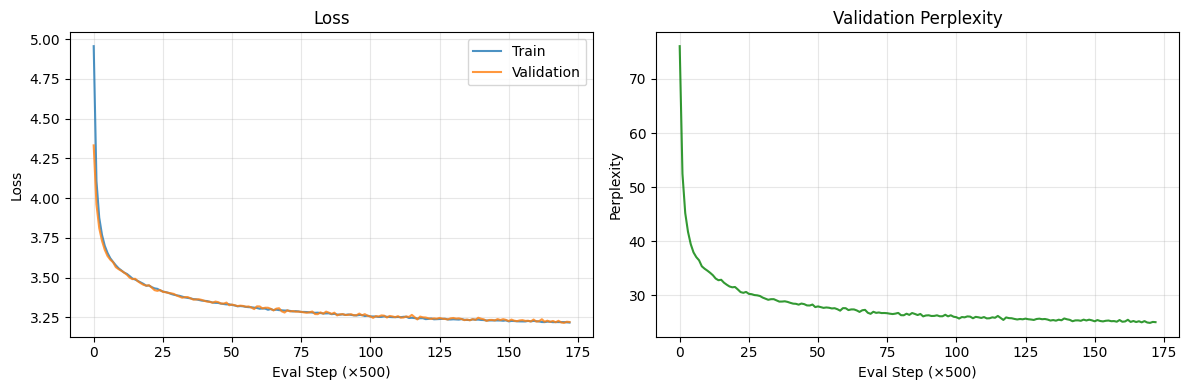


Final validation loss: 3.221
Final validation perplexity: 25.0


In [19]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train', alpha=0.8)
axes[0].plot(history['val_loss'], label='Validation', alpha=0.8)
axes[0].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_perplexity'], color='green', alpha=0.8)
axes[1].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_training_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFinal validation loss: {history['val_loss'][-1]:.3f}")
print(f"Final validation perplexity: {history['val_perplexity'][-1]:.1f}")

---

## 7. Comparison: Did Attention Help?

Let's compare against the bigram model and the n-gram experiments.

In [20]:
# Load previous results
checkpoint_03 = torch.load('03_bigram.pt', map_location='cpu', weights_only=False)

print("=" * 60)
print("COMPARISON: How Much Did Attention Help?")
print("=" * 60)
print()
print(f"{'Model':<30} {'Params':<12} {'Val PPL':<10}")
print("-" * 52)
print(f"{'03: Bigram':<30} {'1,052,672':<12} {checkpoint_03['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'04: Bigram + Attention':<30} {f'{num_params:,}':<12} {history['val_perplexity'][-1]:<10.1f}")
print()

improvement = (checkpoint_03['history']['val_perplexity'][-1] - history['val_perplexity'][-1])
pct_improvement = improvement / checkpoint_03['history']['val_perplexity'][-1] * 100
print(f"Perplexity improvement: {improvement:.1f} ({pct_improvement:.1f}% reduction)")
print()
print("For reference, from notebook 03b:")
print("  4-gram model achieved perplexity ~20")
print("  (but with O(vocab^4) effective parameters)")

COMPARISON: How Much Did Attention Help?

Model                          Params       Val PPL   
----------------------------------------------------
03: Bigram                     1,052,672    35.8      
04: Bigram + Attention         1,118,208    25.0      

Perplexity improvement: 10.7 (30.0% reduction)

For reference, from notebook 03b:
  4-gram model achieved perplexity ~20
  (but with O(vocab^4) effective parameters)


---

## 8. Generation: Does It Sound Different?

Lower perplexity is good, but let's hear what the model actually says.

In [21]:
def generate_and_print(prompt, max_tokens=50, temperature=1.0):
    """Generate from a prompt and print results."""
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    generated_tokens = model.generate(prompt_tokens, max_new_tokens=max_tokens, temperature=temperature)
    generated_text = tokenizer.decode(generated_tokens)
    
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_text}")
    print()


print("=" * 60)
print("GENERATION TEST")
print("=" * 60)
print()

test_prompts = [
    "Once upon a time",
    "The little girl",
    "He was very",
    "She went to the",
]

for prompt in test_prompts:
    generate_and_print(prompt, max_tokens=40)

GENERATION TEST

Prompt: Once upon a time
Generated:  the farmer farmer provided me smile. He followed the farmer's fine. They got dirty. So they made Lily and drank from danger that even agreed. The farmer's face. One day they drove

Prompt: The little girl
Generated:  she could go home.

Prompt: He was very
Generated:  sad. He decided to teach them how to go home, and soon." The people and generous. They held the shop and stopped it back. He ran away.



But then something

Prompt: She went to the
Generated:  park to stay home. She has a bird and the top of candy and a very happy because she found a ribbon around them move and sweet perfume, even more candy as long trunk. Together, Molly



---

## 9. Visualizing Attention: What Is The Model Looking At?

One of the beautiful things about attention is that it's interpretable. We can see *what* the model attends to when making predictions.

Let's look at the attention patterns for a real sentence.

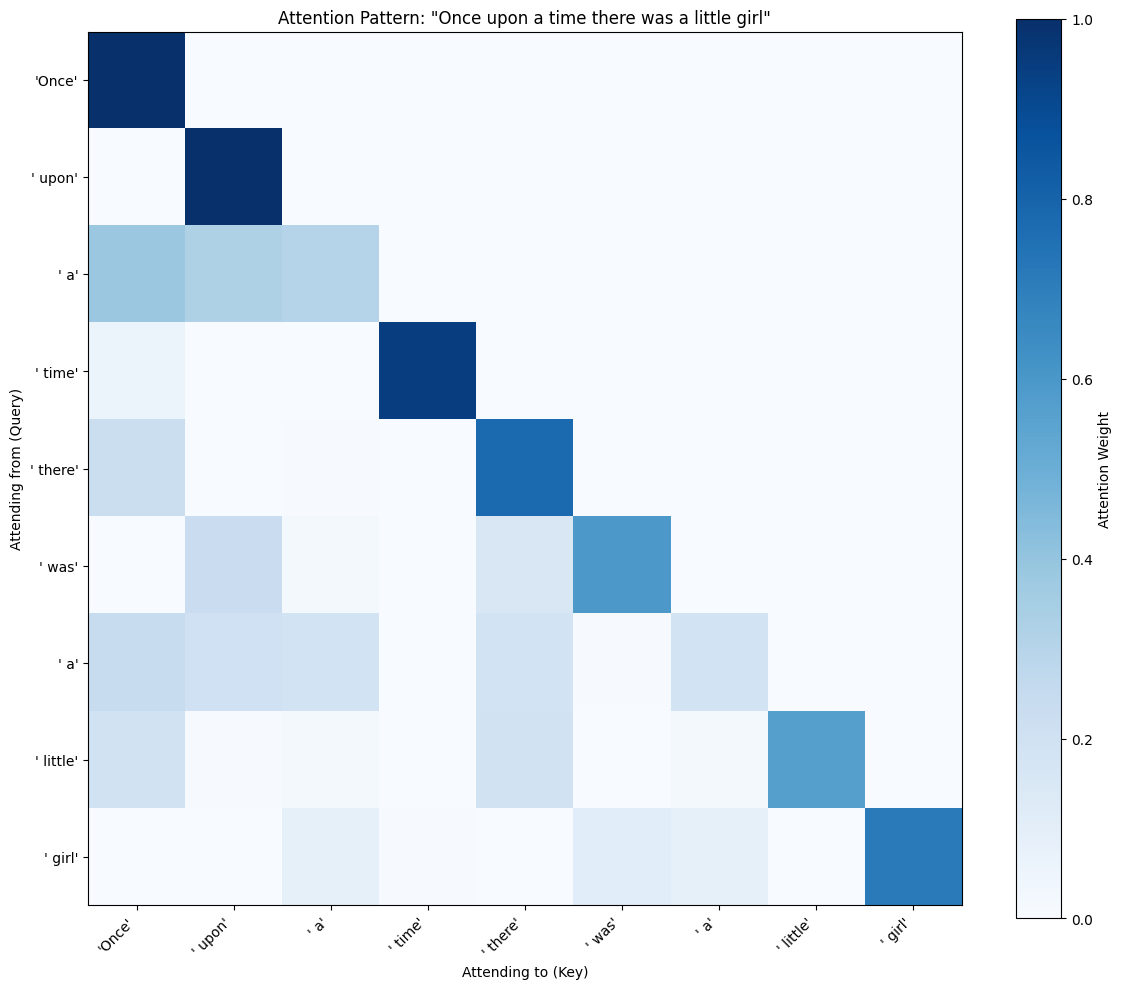


Reading the plot:
  - Each row shows what that position attends to
  - Row 0 can only attend to column 0 (itself)
  - Later rows can attend to all previous positions
  - Bright = high attention, dark = low attention


In [22]:
def visualize_attention(text, figsize=(12, 10)):
    """
    Visualize attention patterns for a given text.
    """
    # Tokenize
    tokens = tokenizer.encode(text, add_eos=False)
    token_strs = [tokenizer.decode_single(t) for t in tokens]
    
    # Get attention weights
    model.eval()
    with torch.no_grad():
        x = torch.tensor([tokens], device=device)
        logits, attn_weights = model(x, return_attention=True)
    
    # Plot
    weights = attn_weights[0].cpu().numpy()  # [seq_len, seq_len]
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(weights, cmap='Blues')
    
    # Labels
    n_tokens = len(tokens)
    ax.set_xticks(range(n_tokens))
    ax.set_yticks(range(n_tokens))
    ax.set_xticklabels([repr(s) for s in token_strs], rotation=45, ha='right')
    ax.set_yticklabels([repr(s) for s in token_strs])
    
    ax.set_xlabel('Attending to (Key)')
    ax.set_ylabel('Attending from (Query)')
    ax.set_title(f'Attention Pattern: "{text}"')
    
    plt.colorbar(im, ax=ax, label='Attention Weight')
    plt.tight_layout()
    
    return fig, weights, token_strs


# Try a classic
fig, weights, tokens = visualize_attention("Once upon a time there was a little girl")
plt.show()

print("\nReading the plot:")
print("  - Each row shows what that position attends to")
print("  - Row 0 can only attend to column 0 (itself)")
print("  - Later rows can attend to all previous positions")
print("  - Bright = high attention, dark = low attention")

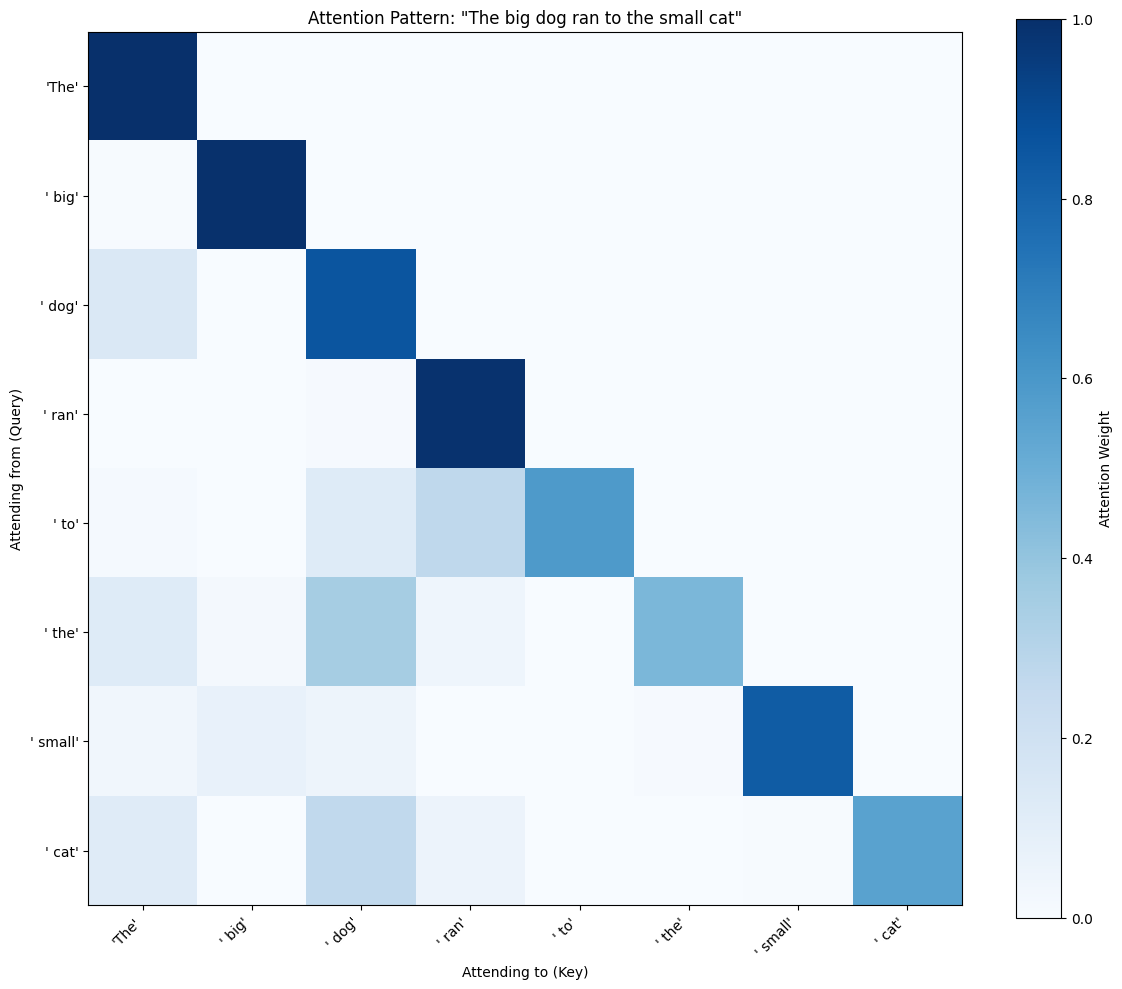


Look for:
  - Does 'ran' attend to 'dog' (subject)?
  - Does 'cat' attend to 'small' (its adjective)?
  - Are there any diagonal patterns (attend to recent tokens)?

Note: Without positional encoding, the model doesn't know WHERE tokens are.
It can only learn WHAT tokens are relevant based on their content.


In [23]:
# Try another sentence and look for patterns
fig, weights, tokens = visualize_attention("The big dog ran to the small cat")
plt.savefig('04_attention_pattern.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nLook for:")
print("  - Does 'ran' attend to 'dog' (subject)?")
print("  - Does 'cat' attend to 'small' (its adjective)?")
print("  - Are there any diagonal patterns (attend to recent tokens)?")
print("\nNote: Without positional encoding, the model doesn't know WHERE tokens are.")
print("It can only learn WHAT tokens are relevant based on their content.")

---

## 10. What Did Attention Learn?

Let's look at some specific attention patterns to understand what the model figured out.

In [24]:
def analyze_attention(text):
    """
    Show what each position attends to most strongly.
    """
    tokens = tokenizer.encode(text, add_eos=False)
    token_strs = [tokenizer.decode_single(t) for t in tokens]
    
    model.eval()
    with torch.no_grad():
        x = torch.tensor([tokens], device=device)
        logits, attn_weights = model(x, return_attention=True)
    
    weights = attn_weights[0].cpu().numpy()
    
    print(f"Text: {text}")
    print(f"Tokens: {token_strs}")
    print()
    print("What each position attends to most:")
    print("-" * 50)
    
    for i in range(len(tokens)):
        # Get top 3 attended positions (excluding padded future)
        row = weights[i, :i+1]
        if len(row) > 1:
            top_indices = np.argsort(row)[-3:][::-1]
            top_weights = row[top_indices]
            attended = [(token_strs[j], f"{w:.2f}") for j, w in zip(top_indices, top_weights)]
        else:
            attended = [(token_strs[0], "1.00")]
        
        print(f"  {token_strs[i]:>12} attends to: {attended}")
    print()


analyze_attention("Once upon a time there was")
analyze_attention("The little girl named Lily was happy")

Text: Once upon a time there was
Tokens: ['Once', ' upon', ' a', ' time', ' there', ' was']

What each position attends to most:
--------------------------------------------------
          Once attends to: [('Once', '1.00')]
          upon attends to: [(' upon', '1.00'), ('Once', '0.00')]
             a attends to: [('Once', '0.38'), (' upon', '0.32'), (' a', '0.30')]
          time attends to: [(' time', '0.94'), ('Once', '0.05'), (' a', '0.00')]
         there attends to: [(' there', '0.77'), ('Once', '0.22'), (' a', '0.01')]
           was attends to: [(' was', '0.60'), (' upon', '0.23'), (' there', '0.15')]

Text: The little girl named Lily was happy
Tokens: ['The', ' little', ' girl', ' named', ' Lily', ' was', ' happy']

What each position attends to most:
--------------------------------------------------
           The attends to: [('The', '1.00')]
        little attends to: [(' little', '0.90'), ('The', '0.10')]
          girl attends to: [(' girl', '0.86'), ('The', '0.14'), 

---

## Summary

### What We Built

A language model with causal self-attention:
- **Input:** Token embeddings
- **Attention:** Each position computes a weighted average of all previous positions
- **Output:** Predict next token from the attended representation

### How Attention Works

1. **Project** each token to Query (what I want), Key (what I offer), Value (what I carry)
2. **Score** every query against every key: `score(i,j) = Q_i · K_j / √d`
3. **Mask** future positions (set to -∞)
4. **Softmax** to get attention weights (each row sums to 1)
5. **Mix** values using attention weights: `output_i = Σ_j weight(i,j) × V_j`

### What Attention Gave Us

- **Variable context:** Every position can see all previous positions
- **Selective focus:** Learned to weight relevant positions more heavily
- **Better perplexity:** Significant improvement over bigram baseline
- **Interpretability:** We can visualize what the model attends to

### What's Missing

The model doesn't know *where* tokens are—only *what* they are. It's permutation-equivariant: shuffling the input (except for the causal mask) gives the same attention pattern.

In notebook 05, we add **positional encoding** so the model knows token positions. Then it can learn patterns like "attend to the token 2 positions back" not just "attend to nouns."

### The Lesson

Attention lets tokens talk to each other. Instead of isolated predictions, each position now has access to all the information that came before it—weighted by learned relevance.

This is the core mechanism of transformers. Everything else (positional encoding, feedforward networks, multiple heads, residual connections) is built on top of this foundation.

In [25]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'd_model': D_MODEL,
    'history': history,
}

torch.save(checkpoint, '04_attention.pt')
print("Model saved to 04_attention.pt")

Model saved to 04_attention.pt


In [26]:
print("=" * 60)
print("NOTEBOOK 04 COMPLETE")
print("=" * 60)
print(f"\nArchitecture: Token → Embed → Attention → Unembed")
print(f"Parameters: {num_params:,}")
print(f"Final perplexity: {history['val_perplexity'][-1]:.1f}")
print()
print("The fish has eyes. It can see what came before.")
print("But it doesn't know where things are—just what they are.")
print("Next: Give it a sense of position.")

NOTEBOOK 04 COMPLETE

Architecture: Token → Embed → Attention → Unembed
Parameters: 1,118,208
Final perplexity: 25.0

The fish has eyes. It can see what came before.
But it doesn't know where things are—just what they are.
Next: Give it a sense of position.
